In [ ]:
# pip uninstall -y gensim

<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Supervized learning with tf-idf
        </h1>
    </div>
</div>

- **[Preprocessing](#pre)**

- **[GridSearch](#gri)**

- **[Resultat](#re)**

- **[Resultat par modeles](#mo)**






Le modèle Bag of Words apprend un vocabulaire à partir de tous les documents, puis modélise chaque document en comptant le nombre de fois où chaque mot apparaît, convertissant donc les données textuelles en données numériques.

Nos données ayant déjà été cleanées et tokenisées , nous allons utiliser le module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer. Cela aura pour effet de pondérer la fréquence d'apparition des mots par un indicateur de similarité (si ce mot est commun ou rare dans tous les documents). Dans cette partie, nous allons éliminer les mots qui apparaissent dans plus de 60% des documents (max_df = 0.6).

la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique.

Nous utiliserons aussi la methode <code>oneVersusRest</code> classifier

Pour préparer nos targets, nous allons utiliser MultiLabelBinarizer de Scikit-Learn puisque nos Tags sont multiples.



Nous allons tester plusieurs métriques sur les modèles  :

- Accuracy score 
- F1 score :
- Jaccard similarity score :
- Recall :
- Precision :


Nous allons egalement tester les taux de predictions rempli, pour choisir les modeles finaux

In [ ]:
# pip install  gensim===3.2.1

In [ ]:
# pip uninstall pyLDAvis

In [ ]:
# pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user

In [1]:
# Import Python libraries
import os
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
import unicodedata
from bs4 import BeautifulSoup
# from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from IPython.core.display import display, HTML
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import timeit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, recall_score, precision_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


from sklearn.linear_model import SGDClassifier
import joblib

In [2]:
from sklearn.multioutput import ClassifierChain, MultiOutputRegressor, MultiOutputClassifier, RegressorChain
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet, RidgeClassifier
from sklearn.svm import LinearSVC
from scipy.stats import reciprocal, uniform

In [ ]:
# from google.colab import drive
# drive.mount('/content/ShardDrives/', force_remount=True)

In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)

In [ ]:
LogisticRegression(multi_class=)

In [4]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
# !python -m pip install -U gensim

In [5]:
# import utils own functions
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/media/ismail/Elements/formation/projet5/livrable/utils.py'>

In [16]:
# data = pd.read_csv("/content/ShardDrives/MyDrive/nlp/stackoverflow_cleaned.csv",sep=";", index_col=0,
data = pd.read_csv("stackoverflow_cleaned.csv", sep=";", index_col=0,
                   converters={
                       "tags": literal_eval,
                       "text": literal_eval
                   }
                   )
data.head()

,tags,full_text,text,score
Id,,,,
5767325,"[javascript, arrays]",How can I remove a specific item from an array? I have an array of numbers and I'm using the method to add elements to it.\nIs there a simple way to remove a specific element from an array?\nI'm looking for the equivalent of something like:\n\nI have to use core JavaScript. Frameworks are not allowed.\n,"[item, array, array, number, method, element, way, element, array, equivalent, something, core, javascript, framework]",10385
7244321,[git],"How do I update or sync a forked repository on GitHub? I forked a project, applied several fixes and created a pull request which was accepted. A few days later, another change was made by another contributor. So my fork doesn't contain that change.\nHow can I get that change into my fork? Do I need to delete and re-create my fork when I have further changes to contribute? Or is there an update button?\n","[repository, github, project, fix, pull, request, day, change, contributor, fork, change, change, fork, fork, change, update, button]",4359
8710619,[java],"Why don't Java's +=, -=, *=, /= compound assignment operators require casting? Until today, I thought that for example:\n\nWas just a shortcut for:\n\nBut if we try this:\n\nThen will not compile but will compile fine.\nDoes it mean that in fact is a shortcut for something like this\n?\n","[java, compound, assignment, operator, today, example, shortcut, fact, shortcut, something]",3779
6245570,[git],"How to get the current branch name in Git? I'm from a Subversion background and, when I had a branch, I knew what I was working on with ""These working files point to this branch"".\nBut with Git I'm not sure when I am editing a file in NetBeans or Notepad++, whether it's tied to the master or another branch.\nThere's no problem with in bash, it tells me what I'm doing.\n","[branch, name, git, subversion, background, branch, file, point, branch, git, file, netbeans, master, branch, problem, bash]",3372
8467424,[bash],"Echo newline in Bash prints literal \n In Bash, tried this:\n\nBut it doesn't print a newline, only . How can I make it print the newline?\nI'm using Ubuntu 11.04 (Natty Narwhal).\n","[echo, newline, bash, print, bash, newline, newline, ubuntu, natty, narwhal]",3050


In [11]:
pd.DataFrame(data.full_text.sample(5))

,full_text
Id,
12665536,"Prevent IIS from killing a Task before it ends I'm building a Logging library that stores everything on an Azure table. Writing to that table obviously takes a lot of time (never more than 1 sec, but it's still too much to make the user wait), so Log method returns a LogResult instance, here's the class\n\nAnd here is how the Log method finishes\n\nTo give the caller the option of waiting for it to complete (if it's a console app, for instance). The issue I'm facing is that IIS shouldn't wait for it before returning the user the response... and if I don't wait for it, IIS doesn't always execute the task. The idea is to show the user a message ""... If you contact us, be sure to mention your issue number, XXX"" and don't make him wait until the log entry has been written.\nIs there any way to force IIS to wait until the task finishes, even after it returned the response? I'm thinking I may need to code a Windows Service that takes the request asynchronously, but it looks like a lot of work just to add a log entry... specially if I can force IIS to wait for it.\nThanks for any ideas!\n"
12094937,"how to highlight/select text in a wpf textbox without focus? I want to highlight selected text in a wpf textbox while the textbox is not focused. In my application, my textbox never gets focus, and every key input is done manually. \nI was wondering if there is a way to highlight the selected text when the textbox is not focused?\nAny help would be appreciated!\n"
12262940,"UseDestinationValue only when destination property is not null How to configure AutoMapper mapping when I want to use behaviour from method, but only when destination property is NOT .\nSomething like that:\n\nEDIT\n\nNow example of usage. I have a class and I want to map it to the class. \nMapping configuration:\n\n\nFirst case - destination property property is NOT NULL. Now I want AutoMapper to use this destination instance of property, because it's not null.\nAnd the logic looks like this:\n\nAutoMapper, because of presence of , will leave the instance and set only property.\nSecond case - destination property property is NULL. Now I want AutoMapper not to use this null instance, but create new one. The question is how to configure the mapping to take into account this case?\nThe logic looks like this:\n\nPROBLEM\nHere I have a problem, because after mapping, the property will be null (because of usage of which is in this case).\n\nREASON\nNHibernate, after getting the entity from the database, puts it into a proxy. So the property of a loaded object is not of a type: , but - so I have to use this type, when I want to save this existing object to the database later. But if this property is , then I can't use a null destination value, so Automapper should create a new instance.\nThanks,\nChris\n"
34139259,"How to randomly shuffle a list that has more permutations than the PRNG's period? I have a list with around 3900 elements that I need to randomly permute to produce a statistical distribution. I looked around and found this Maximal Length of List to Shuffle with Python random.shuffle that explains that the period of the PRNG in Python is , which leads to a list with a maximum length of before it becomes impossible to generate all possible permutations. I am only producing 300-1000 permutations of the list so it unlikely that I will be producing duplicate permutations, however, since this is producing a statistical distribution I would like to have all possible permutations as potential samples. \n"
22022058,"new Array() vs Object.create(Array.prototype) A naive confusion:\n\nBoth objects inherits Array.prototype, but they behave differently with the [] operator. Why?\n"


<a name='pre'></a>

<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Preprocessing
        </h1>
    </div>
</div>

In [19]:
X = data["text"]
y = data['tags']
multilabel_binarizer = MultiLabelBinarizer()
y_encoded = multilabel_binarizer.fit_transform(y)

tfidf = Pipeline([
                ('tfidf', TfidfVectorizer(analyzer="word",
                                          max_df=.6,
                                          min_df=0.005,
                                          tokenizer=None,
                                          preprocessor=' '.join,
                                          stop_words=None,
                                          lowercase=False,
                                          ngram_range=(1, 3)
                                          ))
])


X_train, X_test, y_train , y_test = train_test_split(X , y_encoded, test_size = 0.2, random_state= 0)

In [11]:
multilabel_binarizer.classes_

array(['.net', 'algorithm', 'android', 'angular', 'angularjs', 'arrays',
       'asp.net', 'bash', 'c', 'c#', 'c++', 'c++11', 'css', 'gcc', 'git',
       'google-chrome', 'haskell', 'html', 'ios', 'iphone', 'java',
       'java-8', 'javascript', 'jquery', 'json', 'language-lawyer',
       'linux', 'macos', 'multithreading', 'mysql', 'node.js',
       'objective-c', 'performance', 'php', 'pointers', 'python',
       'python-3.x', 'r', 'reactjs', 'regex', 'ruby', 'ruby-on-rails',
       'sql', 'sql-server', 'string', 'swift', 'typescript',
       'visual-studio', 'windows', 'xcode'], dtype=object)

In [18]:
test = tfidf.fit_transform(X)
joblib.dump(tfidf, 'modeles/tfidf_vectorizer.pkl')

['modeles/tfidf_vectorizer.pkl']

In [12]:
X.shape, y.shape

((93701,), (93701,))

<a name='gri'></a>

<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          gridsearch
        </h1>
    </div>
</div>


Nous allons tester respectivement les modeles suivants avec GridSearchCV:
 <code> 
 
    'multinomial': MultinomialNB(),
    'SGDClassifier': SGDClassifier(),
    'logistic': LogisticRegression(),
    'randomForest': RandomForestClassifier(),
    'RidgeClassifier': RidgeClassifier()
    
</code>    



Dans cette partie, nous allons tester differents algorithme dans un gridSearchCv et oneVSRest avec les metriques

     - accuracy
     - f1
     - jaccard
     - recall
     - precision
     
     
Pour notre modelisation , nous allons tenter de tester des modeles de classification disponibles , ainsi que les comparer entre eux par nos metriques.

Pour cela nous avons creer une classe <code>nlpEstimatorAlgo</code> recuperant une liste de dictionnary (nom modele --> Modele de regression a tester), celui ci les testera un a un dans un GRIDSEARCHCV et renverra les resultats      


In [20]:
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings("ignore")


class nlpEstimatorAlgo:

    def __init__(self, models, params, useLog=True):
        self.models = models
        self.keys = models.keys()
        self.params = params
        self.grid_searches = {}
        self.useLog = useLog
        self.bestParams = {}
        self.scorer = {}
        self.cv_results = {}
        self.scoring = {
            "accuracy": "accuracy",
            "f1": "f1",
            "jaccard": "jaccard",
            "recall": "recall",
            "precision": "precision"
        }
        self.kfold = KFold(n_splits=5)

    def fit(self, X_train, y_train):
        starttotaltime = timeit.default_timer()
        for model_name in self.keys:
            print('Running GridSearchCV for %s.' % model_name)
            starttime = timeit.default_timer()
            model = self.models[model_name]
            params = self.params[model_name]
            print('training model', model)
            # GridSearchCV
            # RandomizedSearchCV

            pipeline = Pipeline([
                ('tfidf', tfidf),
                (model_name, OneVsRestClassifier(model)),
                #                 (model_name,ClassifierChain(model)),
                #                 (model_name,MultiOutputClassifier(model)),
                #                 (model_name,RegressorChain(model)),
            ])

            grid_search = GridSearchCV(
                pipeline,
                params,
                # scoring = self.scoring,
                # scoring = "f1_weighted",
                scoring={
                    "f1_weighted": "f1_weighted",
                    "accuracy": "accuracy",
                },
                return_train_score=True,
                # refit=True,
                refit="f1_weighted",
                cv=self.kfold,
                n_jobs=-1
            )

#             print(grid_search.get_params().keys())
            if model_name == 'randomForest':
                grid_search.fit(X_train[0:7000], y_train[0:7000])
            else:
                grid_search.fit(X_train, y_train)
            self.bestParams[model_name] = grid_search.best_params_
            self.scorer[model_name] = grid_search.best_estimator_
            self.grid_searches[model_name] = grid_search
            self.cv_results[model_name] = grid_search.cv_results_

            elapsed = timeit.default_timer() - starttime
            print('training {} model done'.format(model_name))
            print("elapsed time {:.2f}s".format(elapsed))
        print('All training done.')
        elapsed = timeit.default_timer() - starttotaltime
        print("total time {:.2f}s".format(elapsed))

    def getBestParams(self):
        return self.bestParams

    def showBestParams(self, useindex=False):
        frames = []
        result = pd.DataFrame()
        for name, bestParams in self.bestParams.items():
            frame = pd.DataFrame()
            frame['estimator'] = [name]
            frame['best_params'] = [bestParams]
            frames.append(frame)
        result = pd.concat(frames)
        result = result.reset_index()
        if(useindex):
            result.set_index('estimator', inplace=True)
        result = result.drop(['index'], 1)
        return result

    def getGetScorer(self):
        return self.scorer

    def getCvResults(self):
        return sel.cv_results_

    def getPredictionsResult(self, name, X_test):
        # Predict
        result = pd.DataFrame()
        y_test_predicted_labels = self.grid_searches[name].predict(X_test)
        result['True_Tag'] = multilabel_binarizer.inverse_transform(y_test)
        result['predicted_Tag'] = multilabel_binarizer.inverse_transform(
            y_test_predicted_labels)
        return result

    def getUnTaggedPredictionsByModel(self, X_test):
        frames = []
        result = pd.DataFrame()
        for name, grid_search in self.grid_searches.items():
            frame = pd.DataFrame()
            y_test_predicted_labels = grid_search.predict(X_test)
            tags_per_row = y_test_predicted_labels.sum(axis=1)
            null_rate = round(
                ((tags_per_row.size - np.count_nonzero(tags_per_row))/tags_per_row.size)*100, 2)
            frame['estimator'] = [name]
            frame['untaged'] = str(null_rate) + '%'
            frames.append(frame)
        result = pd.concat(frames)
        return result

    def getClassificationReport(self, name, y_test, X_test):
        y_test_predicted_labels = self.grid_searches[name].predict(X_test)
        print('accuracy model {} : {}'.format(
            name, accuracy_score(y_test_predicted_labels, y_test)))
        report_dict = classification_report(
            y_test, y_test_predicted_labels, output_dict=True, target_names=multilabel_binarizer.classes_)
        return pd.DataFrame(report_dict).T

    def savemodels(self):
        joblib.dump(
            tfidf, '/content/ShardDrives/MyDrive/nlp/tfidf/tfidf_vectorizer.pkl')
        joblib.dump(multilabel_binarizer,
                    '/content/ShardDrives/MyDrive/nlp/tfidf/multilabel_binarizer.pkl')

        for name, grid_search in self.grid_searches.items():
            joblib.dump(
                grid_search, '/content/ShardDrives/MyDrive/nlp/tfidf/'+name+'-tfidf.pkl')

         # renvoie les meilleurs resulats par modele contenu tester sur les variables test

    def getBestModeleScore_scorePrediction(self, useIndex=False):
        frames = []
        result = pd.DataFrame()
        for name, grid_search in self.grid_searches.items():
            frame = pd.DataFrame()
            # grid_search.predict(X_test) is equivalent to grid_search.best_estimator_.predict(X_test)
            # Inverse transform
            y_pred = grid_search.predict(X_test)
            frame['estimator'] = [name]
            frame['accuracy'] = np.round((accuracy_score(y_test, y_pred)), 5)
            frame['f1_macro'] = np.round(
                f1_score(y_test, y_pred, average="macro"), 3)
            frame['f1_micro'] = np.round(
                f1_score(y_test, y_pred, average="micro"), 3)
            frame['jaccard'] = np.round(jaccard_score(
                y_test, y_pred, average="weighted"), 3)
            frame['recall'] = np.round(recall_score(
                y_test, y_pred, average="weighted"), 3)
            frame['precision'] = np.round(precision_score(
                y_test, y_pred, average="weighted"), 3)
            frames.append(frame)
        result = pd.concat(frames)
        result = result.reset_index()
        if(useIndex):
            result.set_index('estimator', inplace=True)
        result = result.drop(['index'], 1)
        return result

    # affiche les meilleurs resulats par modele contenu tester sur les variables test
    def getBestModeleScore_graphpredictions(self):
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_scorePrediction(
            True).plot(kind='bar', figsize=(15, 6))
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x()
                        * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title(
            'Resultats des meilleurs predictions par modeles apres hyperparametrisations')
        plt.show()

#     Generate 3 plots: the test and training learning curve, the training
#     samples vs fit times curve, the fit times vs score curve.
    def getLearningCurveByName(self, model_name, X_train, y_train):
        # Results from grid search
        grid = self.grid_searches[model_name]
        title = "learning curve for model {}".format(model_name)
        estimator = grid.best_estimator_
        estimator = grid.best_estimator_
        utils.plot_learning_curve(
            estimator, title, X_train, y_train, ylim=None, cv=self.kfold, n_jobs=4
        )
        plt.show()

    # Show validation between real values vs predicted values
    def showPredictionbyName(self, name, target, X_train, y_train):
        plot_cross_val_predi(
            self.grid_searches[name].best_estimator_, name, target, X_train, y_train, cv=self.kfold)


models = {
    'multinomial': MultinomialNB(),
    'SGDClassifier': SGDClassifier(),
    'logistic': LogisticRegression(),
    'randomForest': RandomForestClassifier(),
    'RidgeClassifier': RidgeClassifier()
}

params_models = {

    'multinomial': {
        'multinomial__estimator__alpha': [1, 1e-1, 1e-2],
    },
    'SGDClassifier': {
        'SGDClassifier__estimator__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
        'SGDClassifier__estimator__max_iter': [1000],
        'SGDClassifier__estimator__loss': ['log'],
        'SGDClassifier__estimator__penalty': ['l1', 'l2'],
        'SGDClassifier__estimator__n_jobs': [-1]
    },
    'logistic':
    {
        "logistic__estimator__C": [100, 10, 1.0, 0.1],
        "logistic__estimator__penalty": ["l1", "l2"],
        "logistic__estimator__dual": [False],
        "logistic__estimator__solver": ["liblinear"]
    },
    'randomForest': {
        "randomForest__estimator__max_depth": [5, 25, 50],
        "randomForest__estimator__min_samples_leaf": [1, 5, 10],
        "randomForest__estimator__class_weight": ["balanced"]
    },

    'RidgeClassifier': {
        'RidgeClassifier__estimator__max_iter': [1500, 2000, 3000],
        'RidgeClassifier__estimator__alpha': np.arange(0.1, 1, .2).tolist(),
        'RidgeClassifier__estimator__solver': ['auto', 'cholesky']
    },

}

algo_estimator = nlpEstimatorAlgo(models, params_models, True)
algo_estimator.fit(X_train, y_train)

Running GridSearchCV for multinomial.
training model MultinomialNB()
training multinomial model done
elapsed time 54.84s
Running GridSearchCV for SGDClassifier.
training model SGDClassifier()
training SGDClassifier model done
elapsed time 360.68s
Running GridSearchCV for logistic.
training model LogisticRegression()
training logistic model done
elapsed time 540.26s
Running GridSearchCV for randomForest.
training model RandomForestClassifier()
training randomForest model done
elapsed time 312.22s
Running GridSearchCV for RidgeClassifier.
training model RidgeClassifier()
training RidgeClassifier model done
elapsed time 425.06s
All training done.
total time 1693.07s


<a name='res'></a>

<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Resultat
        </h1>
    </div>
</div>

les modeles logistic et SGDCClassifier donnent les meilleurs resultats sur nos metriques

In [22]:
algo_estimator.getBestModeleScore_scorePrediction()

,estimator,accuracy,f1_macro,f1_micro,jaccard,recall,precision
0,multinomial,0.16909,0.272,0.374,0.227,0.244,0.760
1,SGDClassifier,0.29454,0.454,0.543,0.375,0.407,0.777
2,logistic,0.34667,0.543,0.609,0.443,0.499,0.761
3,randomForest,0.25132,0.506,0.581,0.425,0.627,0.565
4,RidgeClassifier,0.26018,0.415,0.501,0.334,0.358,0.791


In [19]:
algo_estimator.savemodels()

In [40]:
algo_estimator.getBestModeleScore_scorePrediction().to_csv(
    "/content/ShardDrives/MyDrive/nlp/tfidf/ntdif_models_resutls.csv")

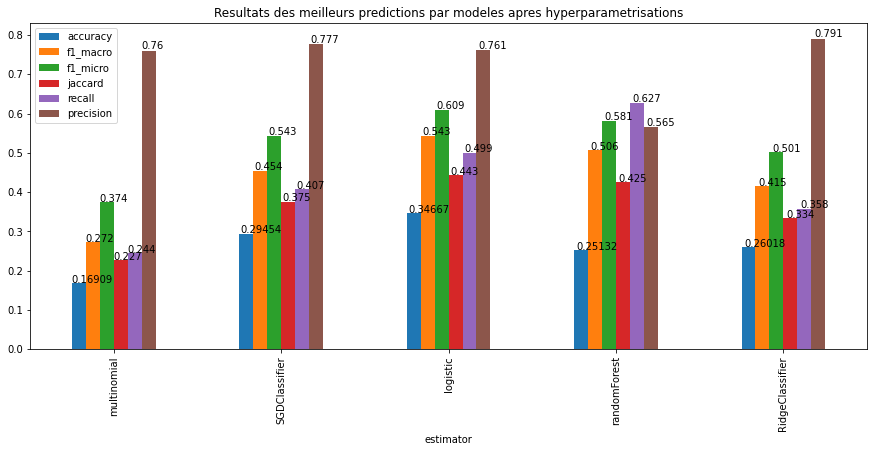

In [23]:
algo_estimator.getBestModeleScore_graphpredictions()

Les modeles logistic et randomForest ont les predictions les plus remplies

In [21]:
algo_estimator.getUnTaggedPredictionsByModel(X_test)

,estimator,untaged
0,multinomial,63.66%
0,SGDClassifier,40.29%
0,logistic,28.45%
0,randomForest,12.36%
0,RidgeClassifier,47.0%


In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [22]:
algo_estimator.showBestParams()

,estimator,best_params
0,multinomial,{'multinomial__estimator__alpha': 0.01}
1,SGDClassifier,"{'SGDClassifier__estimator__alpha': 0.0001, 'SGDClassifier__estimator__loss': 'log', 'SGDClassifier__estimator__max_iter': 1000, 'SGDClassifier__estimator__n_jobs': -1, 'SGDClassifier__estimator__penalty': 'l1'}"
2,logistic,"{'logistic__estimator__C': 100, 'logistic__estimator__dual': False, 'logistic__estimator__penalty': 'l2', 'logistic__estimator__solver': 'liblinear'}"
3,randomForest,"{'randomForest__estimator__class_weight': 'balanced', 'randomForest__estimator__max_depth': 50, 'randomForest__estimator__min_samples_leaf': 5}"
4,RidgeClassifier,"{'RidgeClassifier__estimator__alpha': 0.1, 'RidgeClassifier__estimator__max_iter': 1500, 'RidgeClassifier__estimator__solver': 'auto'}"


<a name='mo'></a>

<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Resultat par modeles
        </h1>
    </div>
</div>

Dans cette partie nous allons analyser plus en detail chaque modele.

- La prediction de tag realiser par le modele vs tag reel
    
- la learning curve du modele (si il y a Under/Over fitting)
    
-  ainsi que la classification report par tag
    

Classificateur Naive Bayes pour les modèles multinomiaux.

Le classificateur multinomial Naive Bayes convient à la classification avec des caractéristiques discrètes (par exemple, le nombre de mots pour la classification de texte). La distribution multinomiale nécessite normalement un nombre entier de caractéristiques. Cependant, en pratique, les comptages fractionnaires tels que tf-idf peuvent également fonctionner.

,True_Tag,predicted_Tag
5397,"(ios, swift, xcode)","(ios, swift, xcode)"
9820,"(performance, sql, sql-server)",()
1580,"(performance,)","(mysql, sql, sql-server)"
13619,"(performance, php)",()
1897,"(ios, swift)",()
13282,"(c#,)",()
1673,"(bash, git, linux)","(git,)"
4469,"(html, ios)",()
1594,"(.net, c#)",()
5807,"(c++,)","(c++,)"


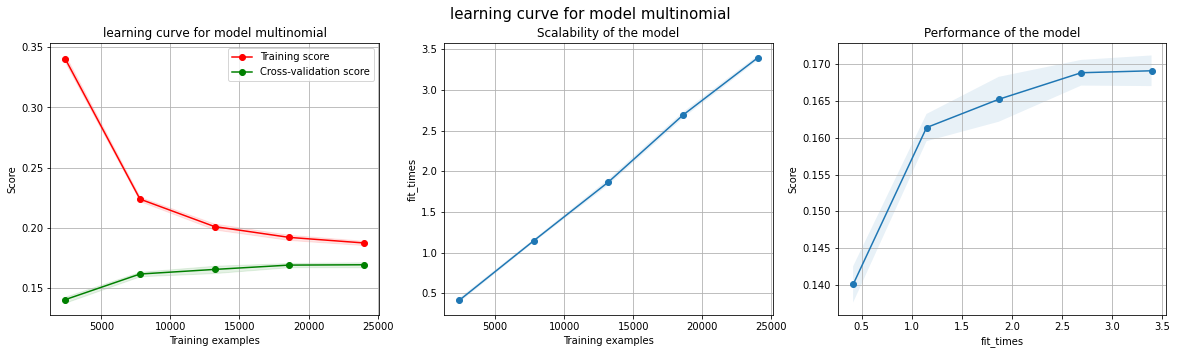

accuracy model multinomial : 0.16909449869270582


,precision,recall,f1-score,support
.net,0.600000,0.005059,0.010033,593.0
algorithm,0.800000,0.290503,0.426230,537.0
android,0.945280,0.506227,0.659351,1365.0
angular,0.925926,0.101215,0.182482,247.0
angularjs,1.000000,0.117073,0.209607,205.0
arrays,0.618705,0.196347,0.298094,438.0
asp.net,0.619048,0.061321,0.111588,212.0
bash,0.878049,0.208092,0.336449,173.0
c,0.696154,0.148239,0.244429,1221.0
c#,0.797794,0.101307,0.179785,2142.0


In [34]:
display(algo_estimator.getPredictionsResult("multinomial", X_test).sample(10))
algo_estimator.getLearningCurveByName(
    'multinomial', X_train[0:30000], y_train[0:30000])
algo_estimator.getClassificationReport("multinomial", y_test, X_test)

La régression **logistique** ou modèle logit est un modèle de régression binomiale. Comme pour tous les modèles de régression binomiale, il s'agit de modéliser au mieux un modèle mathématique simple à des observations réelles nombreuses. En d'autres termes d'associer à un vecteur de variables aléatoires

${\displaystyle (x_{1},\ldots ,x_{K})}(x_{1},\ldots ,x_{K}) $ une variable aléatoire binomiale génériquement notée ${\displaystyle y}$. La régression logistique constitue un cas particulier de modèle linéaire généralisé. Elle est largement utilisée en apprentissage automatique.

,True_Tag,predicted_Tag
5360,"(.net, c#)","(c#,)"
9873,"(javascript,)",()
15822,"(c++, c++11)",()
2187,"(haskell,)","(c,)"
12067,"(python,)",()
3257,"(java,)",()
13870,"(objective-c, swift)","(swift,)"
5783,"(java,)","(java, java-8)"
12847,"(android, java)",()
10042,"(r,)",()


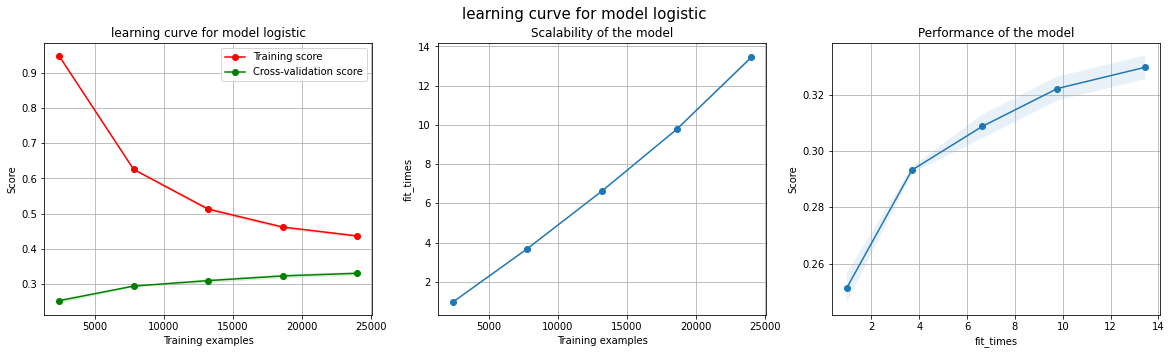

accuracy model logistic : 0.3466197107945147


,precision,recall,f1-score,support
.net,0.582524,0.101180,0.172414,593.0
algorithm,0.770026,0.554935,0.645022,537.0
android,0.932849,0.753114,0.833401,1365.0
angular,0.794702,0.485830,0.603015,247.0
angularjs,0.875000,0.478049,0.618297,205.0
arrays,0.622581,0.440639,0.516043,438.0
asp.net,0.600000,0.226415,0.328767,212.0
bash,0.777778,0.526012,0.627586,173.0
c,0.634218,0.352170,0.452870,1221.0
c#,0.724196,0.399627,0.515042,2142.0


In [35]:
display(algo_estimator.getPredictionsResult("logistic", X_test).sample(10))
algo_estimator.getLearningCurveByName(
    'logistic', X_train[0:30000], y_train[0:30000])
algo_estimator.getClassificationReport("logistic", y_test, X_test)

**Random Forest** : C'est une technique à base d'arbres qui utilise un très grand nombre d'arbres de décisions construits à partir d'ensembles de caractéristiques aléatoirement sélectionnés. Contrairement à un simple arbre de décision, il n'est pas interprétable du tout mais le fait qu'il ait une bonne performance en fait un algorithme populaire.

,True_Tag,predicted_Tag
3811,"(ios, objective-c)","(ios, objective-c, swift)"
13414,"(c++,)","(c#, c++, c++11)"
11863,"(ios, swift)",()
9189,"(google-chrome, html, javascript, jquery)","(css, google-chrome, html, javascript, jquery)"
18232,"(html, java)","(html, javascript)"
9406,"(android,)","(android,)"
17425,"(c++,)",()
16385,"(.net,)","(.net, c#)"
1426,"(reactjs, typescript)",()
16806,"(php,)","(mysql, php, sql)"


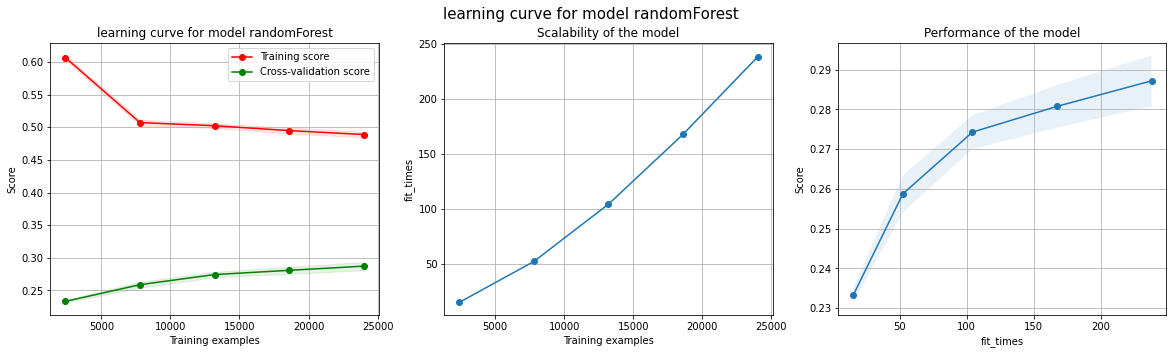

accuracy model randomForest : 0.25815057894456006


,precision,recall,f1-score,support
.net,0.327791,0.232715,0.272189,593.0
algorithm,0.597222,0.640596,0.618149,537.0
android,0.763585,0.792674,0.777858,1365.0
angular,0.615044,0.562753,0.587738,247.0
angularjs,0.428571,0.087805,0.145749,205.0
arrays,0.408163,0.730594,0.523732,438.0
asp.net,0.488889,0.311321,0.380403,212.0
bash,0.566372,0.369942,0.447552,173.0
c,0.404915,0.566749,0.472355,1221.0
c#,0.489525,0.567227,0.525519,2142.0


In [36]:
display(algo_estimator.getPredictionsResult("randomForest", X_test).sample(10))
algo_estimator.getLearningCurveByName(
    'randomForest', X_train[0:30000], y_train[0:30000])
algo_estimator.getClassificationReport("randomForest", y_test, X_test)

Le modele **SGDClassifier** implémente une routine d'apprentissage de descente de gradient stochastique simple qui prend en charge différentes fonctions de perte et pénalités pour la classification.

La descente de gradient stochastique (SGD) est une approche simple mais très efficace pour ajuster les classificateurs linéaires et les régresseurs sous des fonctions de perte convexes telles que les machines à vecteurs de support (linéaires) et la régression logistique . Même si SGD existe depuis longtemps dans la communauté de l'apprentissage automatique, il a récemment reçu une attention considérable dans le contexte de l'apprentissage à grande échelle.


Les avantages de Stochastic Gradient Descent sont :

Efficacité.

Facilité de mise en œuvre (nombreuses possibilités de réglage du code).

Les inconvénients de Stochastic Gradient Descent incluent :

SGD nécessite un certain nombre d'hyperparamètres tels que le paramètre de régularisation et le nombre d'itérations.

SGD est sensible à la mise à l'échelle des fonctionnalités.



,True_Tag,predicted_Tag
17011,"(c#,)",()
15960,"(mysql, sql-server)","(mysql, sql-server)"
2395,"(css,)","(css,)"
936,"(angular, typescript)","(angular, reactjs)"
8280,"(reactjs,)",()
4756,"(c++,)",()
9409,"(c++, language-lawyer)","(c, c++)"
16271,"(c#, performance)","(performance,)"
16142,"(java,)","(java,)"
3738,"(css, html)",()


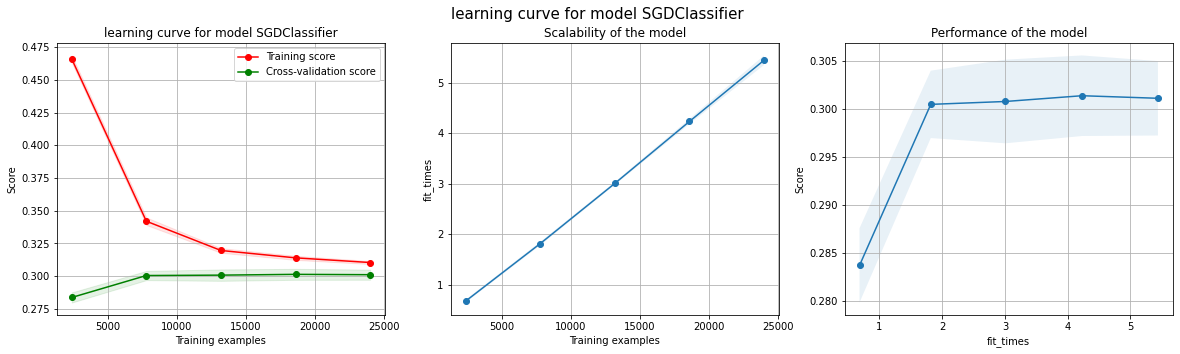

accuracy model SGDClassifier : 0.295928712448642


,precision,recall,f1-score,support
.net,0.571429,0.053963,0.098613,593.0
algorithm,0.815900,0.363128,0.502577,537.0
android,0.949898,0.680586,0.793000,1365.0
angular,0.784483,0.368421,0.501377,247.0
angularjs,0.939394,0.302439,0.457565,205.0
arrays,0.612782,0.372146,0.463068,438.0
asp.net,0.615385,0.150943,0.242424,212.0
bash,0.811765,0.398844,0.534884,173.0
c,0.616822,0.216216,0.320194,1221.0
c#,0.784636,0.267040,0.398467,2142.0


In [37]:
display(algo_estimator.getPredictionsResult(
    "SGDClassifier", X_test).sample(10))
algo_estimator.getLearningCurveByName(
    'SGDClassifier', X_train[0:30000], y_train[0:30000])
algo_estimator.getClassificationReport("SGDClassifier", y_test, X_test)

Ce classificateur convertit d'abord les valeurs cibles  puis traite le problème comme une tâche de régression (régression multi-sorties dans le cas multiclasse)

Pour la classification multi-classes, les classificateurs n_class sont entraînés dans une approche un contre tous. Concrètement, cela est mis en œuvre en tirant parti de la prise en charge de la réponse multivariée dans Ridge.



,True_Tag,predicted_Tag
6766,"(python, python-3.x)","(multithreading,)"
4199,"(c++,)",()
10624,"(android,)",()
14683,"(.net, c#)",()
16522,"(sql,)","(sql,)"
1198,"(python,)",()
95,"(c++, multithreading)",()
11632,"(git,)",()
9550,"(google-chrome, html, javascript)","(html,)"
6214,"(swift,)",()


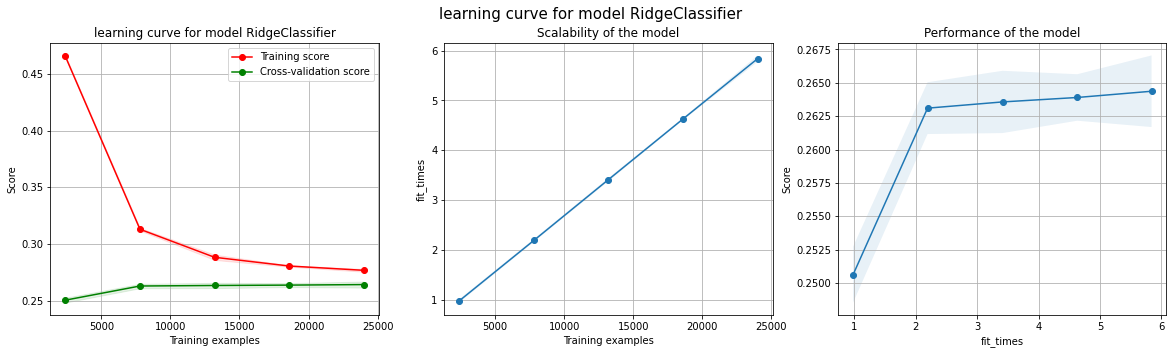

accuracy model RidgeClassifier : 0.260178218878395


,precision,recall,f1-score,support
.net,0.600000,0.055649,0.101852,593.0
algorithm,0.807882,0.305400,0.443243,537.0
android,0.968176,0.579487,0.725023,1365.0
angular,0.796296,0.348178,0.484507,247.0
angularjs,0.984615,0.312195,0.474074,205.0
arrays,0.617530,0.353881,0.449927,438.0
asp.net,0.593220,0.165094,0.258303,212.0
bash,0.817073,0.387283,0.525490,173.0
c,0.661765,0.147420,0.241125,1221.0
c#,0.784247,0.213819,0.336023,2142.0


In [38]:
display(algo_estimator.getPredictionsResult(
    "RidgeClassifier", X_test).sample(10))
algo_estimator.getLearningCurveByName(
    'RidgeClassifier', X_train[0:30000], y_train[0:30000])
algo_estimator.getClassificationReport("RidgeClassifier", y_test, X_test)

A partir des resultats ci dessus, les modeles 	SGDClassifier et logistic ont les meilleurs resultats avec TF-IDF

<a name='mo'></a>

<div class="bg-primary text-lg-left text-white">
    <div>
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          API disponlible
        </h1>
    </div>

</div>
    <div class="text-lg-left ">
       <a href="https://github.com/ismailazdad/stackoverflowTags" target="_blank">stackoverflow</a>
    </div>
     <div>       
       <a href="http://ismail2233.pythonanywhere.com/" target="_blank">online version</a>
    </div>



In [39]:
from sklearn.metrics import multilabel_confusion_matrix
y_test_predicted_labels = algo_estimator.grid_searches['logistic'].predict(
    X_test)
print(multilabel_confusion_matrix(y_test, y_test_predicted_labels))

[[[18105    43]
  [  533    60]]

 [[18115    89]
  [  239   298]]

 [[17302    74]
  [  337  1028]]

 [[18463    31]
  [  127   120]]

 [[18522    14]
  [  107    98]]

 [[18186   117]
  [  245   193]]

 [[18497    32]
  [  164    48]]

 [[18542    26]
  [   82    91]]

 [[17272   248]
  [  791   430]]

 [[16273   326]
  [ 1286   856]]

 [[15618   536]
  [ 1213  1374]]

 [[18201    56]
  [  418    66]]

 [[17892    92]
  [  206   551]]

 [[18501    39]
  [   94   107]]

 [[18423    19]
  [   29   270]]

 [[18519    41]
  [   85    96]]

 [[18564    10]
  [   52   115]]

 [[17635   189]
  [  514   403]]

 [[17694   167]
  [  356   524]]

 [[18533    42]
  [  131    35]]

 [[16380   140]
  [  966  1255]]

 [[18551    26]
  [  103    61]]

 [[16149   316]
  [ 1091  1185]]

 [[17984    75]
  [  301   381]]

 [[18455    32]
  [   95   159]]

 [[18478    41]
  [  165    57]]

 [[18411    39]
  [  227    64]]

 [[18561    24]
  [  110    46]]

 [[18433    51]
  [  135   122]]

 [[18318    57

In [ ]:


X_test.shape

Word2vec